In [7]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [125]:
X_train = pd.read_csv('datasets/final_data_train_delivery1.csv', index_col=0)
y_train = pd.read_csv('datasets/scaled_target_train_delivery1.csv', index_col=0)
X_val = pd.read_csv('datasets/final_data_val_delivery1.csv', index_col=0)
y_val = pd.read_csv('datasets/scaled_target_val_delivery1.csv', index_col=0)
X_test = pd.read_csv('datasets/final_data_test_delivery1.csv', index_col=0)

# 4. Modelling

In [4]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Assuming X_train_oversampled, X_test_new, y_train_oversampled, y_val_binary are defined elsewhere in the notebook

from sklearn.metrics import f1_score, precision_score, recall_score


def evaluate_models(X_train, X_test, y_train, y_val, models):
    metrics = {
        'time': [],
        'train_f1': [],
        'val_f1': [],
        'precision': [],
        'recall': [],
    }

    for model_name, model in models.items():
        # Train the model
        begin = time.perf_counter()
        model.fit(X_train, y_train)
        end = time.perf_counter()

        # Make predictions on training and validation sets
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate precision, recall, and F1 scores
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')  # Updated
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')        # Updated
        precision = precision_score(y_val, y_val_pred, average='weighted')  # Updated
        recall = recall_score(y_val, y_val_pred, average='weighted')        # Updated

        metrics['time'].append(end - begin)
        metrics['train_f1'].append(train_f1)
        metrics['val_f1'].append(val_f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)

    avg_time = np.mean(metrics['time'])
    avg_train_f1 = np.mean(metrics['train_f1'])
    avg_val_f1 = np.mean(metrics['val_f1'])
    avg_precision = np.mean(metrics['precision'])
    avg_recall = np.mean(metrics['recall'])

    std_time = np.std(metrics['time'])
    std_train_f1 = np.std(metrics['train_f1'])
    std_val_f1 = np.std(metrics['val_f1'])
    std_precision = np.std(metrics['precision'])
    std_recall = np.std(metrics['recall'])

    return avg_time, avg_train_f1, avg_val_f1, avg_precision, avg_recall, std_time, std_train_f1, std_val_f1, std_precision, std_recall


def show_results(df, X_train, X_test, y_train, y_val, models):
    count = 0

    for model_name, model in models.items():
        avg_time, avg_train_f1, avg_val_f1, avg_precision, avg_recall, std_time, std_train_f1, std_val_f1, std_precision, std_recall = evaluate_models(X_train, X_test, y_train, y_val, {model_name: model})

        # Ensure the DataFrame has enough rows
        if count >= len(df):
            df.loc[df.shape[0]] = [np.nan] * df.shape[1]

        # Calculate overfitting
        overfitting = avg_train_f1 - avg_val_f1

        # Assign values to the DataFrame
        df.iloc[count] = f"{avg_time:.3f}+/-{std_time:.2f}", f"{avg_train_f1:.3f}+/-{std_train_f1:.2f}", f"{avg_val_f1:.3f}+/-{std_val_f1:.2f}", f"{overfitting:.3f}", f"{avg_precision:.3f}+/-{std_precision:.2f}", f"{avg_recall:.3f}+/-{std_recall:.2f}"
        count += 1

    return df

models_to_evaluate = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'MultiLayerPerceptron': MLPClassifier(),
}

df_all = pd.DataFrame(
    columns=['Time', 'Train_F1', 'Validation_F1', 'Overfitting', 'Precision', 'Recall'],
    index=list(models_to_evaluate.keys())
)

show_results(df_all, X_train, X_test, y_train, y_val, models_to_evaluate)


KeyboardInterrupt: 

**Logistic Regression**

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Initialize the Logistic Regression model
logistic_model = LogisticRegression()
# Fit the model on the training data
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [106]:
# Make predictions on the training set
train_pred = logistic_model.predict(X_train)

# Make predictions on the validation set
val_pred = logistic_model.predict(X_val)

In [107]:
# Evaluate performance on the training data (optional, for overfitting detection)
print("Training Data Evaluation:")
print(f"Accuracy (Train): {accuracy_score(y_train, train_pred)}")
print(f"F1 Score (Train): {f1_score(y_train, train_pred, average='weighted')}")

# Evaluate performance on the validation data
print("\nValidation Data Evaluation:")
print(f"Accuracy (Validation): {accuracy_score(y_val, val_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, val_pred, average='weighted')}")

# Generate classification report for validation
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_pred))

Training Data Evaluation:
Accuracy (Train): 0.717916489440507
F1 Score (Train): 0.6657963030727471

Validation Data Evaluation:
Accuracy (Validation): 0.7204067743112751
F1 Score (Validation): 0.668057540546937

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.51      0.22      0.31      1804
           1       0.81      0.94      0.87     51601
           2       0.13      0.03      0.05     12361
           3       0.64      0.83      0.72     26154
           4       0.47      0.22      0.30      8644
           5       0.00      0.00      0.00       736
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        63

    accuracy                           0.72    101383
   macro avg       0.32      0.28      0.28    101383
weighted avg       0.64      0.72      0.67    101383




Confusion Matrix as DataFrame:
          Predicted_0  Predicted_1  Predicted_2  Predicted_3  Predicted_4  \
Actual_0          756          967           22           57            2   
Actual_1          290        49457          791         1042           20   
Actual_2           12         7268          663         3914          504   
Actual_3           15         1930         1101        21311         1797   
Actual_4            0           47          115         4121         4361   
Actual_5            0            5            4          639           88   
Actual_6            0            0            0           20            0   
Actual_7            0           11            4           46            0   

          Predicted_5  Predicted_6  Predicted_7  
Actual_0            0            0            0  
Actual_1            0            0            1  
Actual_2            0            0            0  
Actual_3            0            0            0  
Actual_4            0   

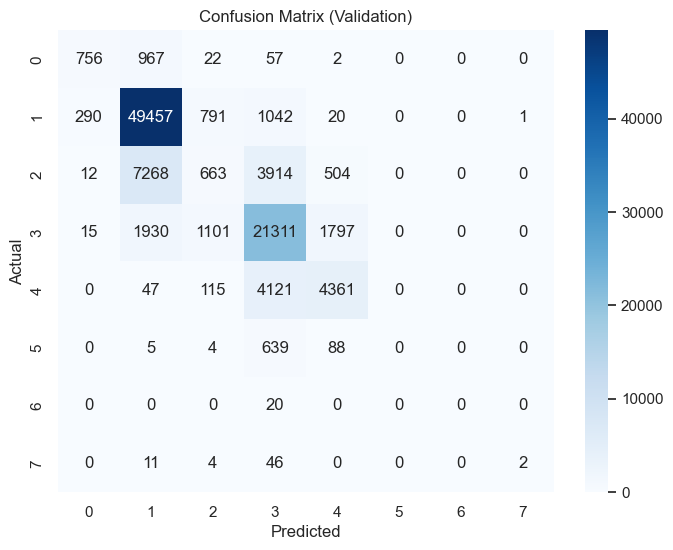

In [ ]:
# Generate  the confusion matrix
conf_matrix = confusion_matrix(y_val, val_pred)

# Convert the confusion matrix into a DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=[f"Actual_{label}" for label in logistic_model.classes_], 
    columns=[f"Predicted_{label}" for label in logistic_model.classes_]
)
print("\nConfusion Matrix as DataFrame:")
print(conf_matrix_df)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=logistic_model.classes_, yticklabels=logistic_model.classes_)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Random Forest**

In [ ]:
# Define the function to find the best number of trees (from the earlier example)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def find_best_n_estimators(X_train, y_train, X_val, y_val, n_estimators_range):
    results = []

    for n in n_estimators_range:
        rf_model = RandomForestClassifier(n_estimators=n, random_state=42, class_weight='balanced')
        rf_model.fit(X_train, y_train)
        val_pred = rf_model.predict(X_val)
        f1 = f1_score(y_val, val_pred, average='weighted')
        results.append({'n_estimators': n, 'F1 Score': f1})
        print(f"n_estimators: {n}, F1 Score: {f1}")

    results_df = pd.DataFrame(results)
    best_n_estimators = results_df.loc[results_df['F1 Score'].idxmax(), 'n_estimators']
    print(f"\nBest n_estimators: {best_n_estimators} with F1 Score: {results_df['F1 Score'].max()}")

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['n_estimators'], results_df['F1 Score'], marker='o')
    plt.title('F1 Score vs. Number of Trees (n_estimators)')
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('F1 Score')
    plt.grid()
    plt.show()

    return best_n_estimators, results_df

In [ ]:
# Step 1: Define the range of n_estimators
n_estimators_range = range(10, 201, 10)

In [ ]:
# Step 2: Find the best number of trees
best_n, results_df = find_best_n_estimators(X_train, y_train, X_val, y_val, n_estimators_range)

n_estimators: 10, F1 Score: 0.7102818091197147
n_estimators: 20, F1 Score: 0.7156989000491586
n_estimators: 30, F1 Score: 0.7173452547332249
n_estimators: 40, F1 Score: 0.7171714910540535
n_estimators: 50, F1 Score: 0.7178192613048378
n_estimators: 60, F1 Score: 0.718133915362094
n_estimators: 70, F1 Score: 0.7173585848694043
n_estimators: 80, F1 Score: 0.7173782067350927
n_estimators: 90, F1 Score: 0.7171898047495949
n_estimators: 100, F1 Score: 0.7181711968695963
n_estimators: 110, F1 Score: 0.7178708832032695
n_estimators: 120, F1 Score: 0.7180243417063347
n_estimators: 130, F1 Score: 0.7171923680113598


KeyboardInterrupt: 

In [ ]:
# Step 3: Train the final Random Forest model with the best number of trees
random_forest_model = RandomForestClassifier(
    n_estimators=best_n, 
    random_state=42, 
    class_weight='balanced'
)

random_forest_model.fit(X_train, y_train)

# Step 4: Make predictions and evaluate the final model
train_pred = random_forest_model.predict(X_train)
val_pred = random_forest_model.predict(X_val)

In [ ]:
print("\nTraining Data Evaluation:")
print(f"Accuracy (Train): {accuracy_score(y_train, train_pred)}")
print(f"F1 Score (Train): {f1_score(y_train, train_pred, average='weighted')}")

print("\nValidation Data Evaluation:")
print(f"Accuracy (Validation): {accuracy_score(y_val, val_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, val_pred, average='weighted')}")

print("\nClassification Report (Validation):")
print(classification_report(y_val, val_pred))

In [ ]:
conf_matrix = confusion_matrix(y_val, val_pred)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f"Actual_{label}" for label in random_forest_model.classes_],
    columns=[f"Predicted_{label}" for label in random_forest_model.classes_]
)

print("\nConfusion Matrix as DataFrame:")
print(conf_matrix_df)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=random_forest_model.classes_, yticklabels=random_forest_model.classes_)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
print('\nF1 Score to the Train dataset:', f1_score(y_train, y_train_rf))
print('F1 Score to the Validation dataset:', f1_score(y_val, y_pred_rf))
print('kaggle result: (score) version x' )

**Gradient Boosting**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best model
best_gb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 486 candidates, totalling 1458 fits


KeyboardInterrupt: 

In [ ]:
# Train the optimized model
best_gb.fit(X_train, y_train)

# Make predictions
y_val_pred_optimized = best_gb.predict(X_test)

# Evaluate performance
print("Optimized Gradient Boosting Performance:")
print(classification_report(y_val, y_val_pred_optimized))
optimized_f1 = f1_score(y_val, y_val_pred_optimized, average='weighted')
print(f"Optimized F1 Score (Weighted): {optimized_f1:.3f}")


**DecisionTree**

**NaiveBayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Gaussian Naive Bayes model with variance smoothing
gnb_model = GaussianNB(var_smoothing=1e-9)

# Fit the model on the training data
gnb_model.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Make predictions on the training set
train_pred = gnb_model.predict(X_train)

# Make predictions on the validation set
val_pred = gnb_model.predict(X_val)


In [ ]:
# Evaluate performance on the training data
print("Training Data Evaluation:")
print(f"Accuracy (Train): {accuracy_score(y_train, train_pred)}")
print(f"F1 Score (Train): {f1_score(y_train, train_pred, average='weighted')}")

# Evaluate performance on the validation data
print("\nValidation Data Evaluation:")
print(f"Accuracy (Validation): {accuracy_score(y_val, val_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, val_pred, average='weighted')}")

# Generate classification report for validation
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_pred))


Training Data Evaluation:
Accuracy (Train): 0.11443393566331968
F1 Score (Train): 0.15794169072312642

Validation Data Evaluation:
Accuracy (Validation): 0.11442746811595632
F1 Score (Validation): 0.15835427775208483

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.40      0.52      0.45      1804
           1       0.86      0.14      0.24     51601
           2       0.16      0.04      0.06     12361
           3       0.39      0.01      0.03     26154
           4       0.11      0.27      0.15      8644
           5       0.01      0.34      0.02       736
           6       0.00      0.25      0.00        20
           7       0.00      0.48      0.00        63

    accuracy                           0.11    101383
   macro avg       0.24      0.26      0.12    101383
weighted avg       0.58      0.11      0.16    101383




Confusion Matrix as DataFrame:
          Predicted_0  Predicted_1  Predicted_2  Predicted_3  Predicted_4  \
Actual_0          936           29           11            6          200   
Actual_1         1158         7267         1499          417        11798   
Actual_2           91          620          455           83         2646   
Actual_3          127          466          709          353         4859   
Actual_4           31           42          116           37         2304   
Actual_5            0            0            5            2           42   
Actual_6            0            0            0            1            0   
Actual_7            0            3            0            0            2   

          Predicted_5  Predicted_6  Predicted_7  
Actual_0          187          295          140  
Actual_1         9594        12816         7052  
Actual_2         3098         3925         1443  
Actual_3         7302         9009         3329  
Actual_4         3063   

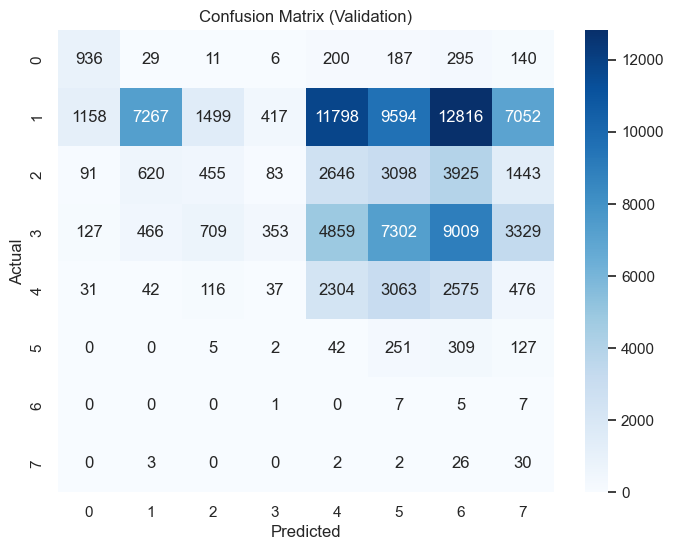

In [ ]:
# Generate and visualize the confusion matrix
conf_matrix = confusion_matrix(y_val, val_pred)

# Convert the confusion matrix into a DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=[f"Actual_{label}" for label in gnb_model.classes_], 
    columns=[f"Predicted_{label}" for label in gnb_model.classes_]
)

# Display the confusion matrix as a DataFrame
print("\nConfusion Matrix as DataFrame:")
print(conf_matrix_df)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gnb_model.classes_, yticklabels=gnb_model.classes_)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**MultiLayerPerceptron**

**KNN**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import pandas as pd

def find_best_k(X_train, y_train, X_val, y_val, ks):
    results = []  # Correct indentation for results initialization

    for k in ks:
        # Initialize the KNN model with the current k
        knn_model = KNeighborsClassifier(n_neighbors=k)

        # Fit the model to the training data
        knn_model.fit(X_train, y_train)

        # Predict on the validation set
        val_pred = knn_model.predict(X_val)

        # Calculate the F1 Macro score
        f1_macro = f1_score(y_val, val_pred, average='macro')
        results.append({'k': k, 'F1 Macro': f1_macro})

        # Print results for each k
        print(f"k: {k}, F1 Macro: {f1_macro}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Find the best k
    best_k = results_df.loc[results_df['F1 Macro'].idxmax(), 'k']
    print(f"\nBest k: {best_k} with F1 Macro: {results_df['F1 Macro'].max()}")

    # Plot the F1 Macro scores
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['k'], results_df['F1 Macro'], marker='o')
    plt.title('F1 Macro vs. Number of Neighbors (k)')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('F1 Macro Score')
    plt.grid()
    plt.show()

    return best_k, results_df


In [ ]:
best_k = 5  # Example

# Initialize the KNN model with the best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Fit the model on the training data
knn_model.fit(X_train, y_train)



In [ ]:
# Make predictions on the training set
train_pred = knn_model.predict(X_train)

# Make predictions on the validation set
val_pred = knn_model.predict(X_val)

In [ ]:
# Evaluate performance on the training data
print("Training Data Evaluation:")
print(f"Accuracy (Train): {accuracy_score(y_train, train_pred)}")
print(f"F1 Score (Train): {f1_score(y_train, train_pred, average='weighted')}")

# Evaluate performance on the validation data
print("\nValidation Data Evaluation:")
print(f"Accuracy (Validation): {accuracy_score(y_val, val_pred)}")
print(f"F1 Score (Validation): {f1_score(y_val, val_pred, average='weighted')}")

# Generate classification report for validation data
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_pred))


In [ ]:
# Generate confusion matrix for validation data
conf_matrix = confusion_matrix(y_val, val_pred)

# Convert confusion matrix to a DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f"Actual_{label}" for label in knn_model.classes_],
    columns=[f"Predicted_{label}" for label in knn_model.classes_]
)

# Display the confusion matrix as a DataFrame
print("\nConfusion Matrix as DataFrame:")
print(conf_matrix_df)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Embedded Methods

**Voting Classifier**

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the individual models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
gradient_boosting_model = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Combine models in a VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', logistic_model),
        ('rf', random_forest_model),
        ('gb', gradient_boosting_model)
    ],
    voting='soft'  # Soft voting for probability-based aggregation
)

In [ ]:
# Train the ensemble model
voting_clf.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
# Make predictions on the training set
train_pred = voting_clf.predict(X_train)

# Make predictions on the validation set
val_pred = voting_clf.predict(X_val)

In [ ]:
# Evaluate the ensemble on the training set
print("Training Data Evaluation:")
print(f"Accuracy (Train): {accuracy_score(y_train, train_pred):.4f}")
print(f"F1 Score (Train): {f1_score(y_train, train_pred, average='weighted'):.4f}")

# Evaluate the ensemble on the validation set
print("\nValidation Data Evaluation:")
print(f"Accuracy (Validation): {accuracy_score(y_val, val_pred):.4f}")
print(f"F1 Score (Validation): {f1_score(y_val, val_pred, average='weighted'):.4f}")

# Generate classification report for validation data
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_pred))

In [ ]:
# Generate confusion matrix for validation data
conf_matrix = confusion_matrix(y_val, val_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=voting_clf.classes_, yticklabels=voting_clf.classes_)
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [117]:
X_test

,Average Weekly Wage,Attorney/Representative,C-3 Date,C-2 Date,WCIO Part Of Body Code_42.0,WCIO Cause of Injury Code_56.0
Claim Identifier,,,,,,
6165911,NaN,0,1,0,0.0,0.0
6166141,NaN,0,1,0,0.0,0.0
6165907,0.0,0,1,0,0.0,0.0
6166047,0.0,0,1,0,0.0,0.0
6166102,0.0,0,1,0,0.0,0.0
...,...,...,...,...,...,...
6553137,NaN,0,1,0,0.0,0.0
6553119,0.0,1,0,1,0.0,0.0
6553542,0.0,1,1,1,0.0,0.0


**Kaggle Submissions**

In [128]:
# substitute the nan values with the mean of the column
X_test = X_test.fillna(X_test.mean())

In [130]:
# Assuming logistic_model is already trained and X_test_encoded is prepared

# Make predictions on the test data
pred_RF = logistic_model.predict(X_test)

# Map the numerical predictions to injury types
label_mapping = {
    0: "1. CANCELLED",
    1: "2. NON-COMP",
    2: "3. MED ONLY",
    3: "4. TEMPORARY",
    4: "5. PPD SCH LOSS",
    5: "6. PPD NSL",
    6: "7. PTD",
    7: "8. DEATH",
    8: "Unknown"
}

predictions = [label_mapping[label] for label in pred_RF]

# Ensure 'Claim Identifier' is the index
submission_df = pd.DataFrame({
    'Claim Identifier': X_test.index,  # Use the index as the Claim Identifier
    'Claim Injury Type': predictions
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
